# Example 2: Taylor Green Vortices on GPU

In [1]:
using MHDFlows,PyPlot,CUDA
using LinearAlgebra: mul!, ldiv!

┌ Info: FourierFlows will use 4 threads
└ @ FourierFlows /home/doraho/.julia/packages/FourierFlows/DtzuG/src/FourierFlows.jl:123


In [2]:
device()

CuDevice(0): NVIDIA GeForce RTX 3080

In [3]:
function ProblemGeneratorTG!(prob,L0;N = prob.grid.nx)
    
  # Output Setting  
  xx,yy,zz = fill(0.0,N,N,N),fill(0.0,N,N,N),fill(0.0,N,N,N);
  
  l = 2*2*π/L0;
    
  for k ∈ 1:N, j ∈ 1:N, i ∈ 1:N
    xx[i,j,k] = l*prob.grid.x[i];
    yy[i,j,k] = l*prob.grid.y[j];
    zz[i,j,k] = l*prob.grid.z[k];
  end
    
  sl=1; sk=1; sm=1; lamlkm=sqrt(sl.^2+sk.^2+sm.^2);

  ux = @. -0.5*(lamlkm*sl*cos(sk*xx).*sin(sl*yy).*sin(sm.*zz) + sm*sk*sin(sk*xx).*cos(sl*yy).*cos(sm.*zz));
  uy=  @.  0.5*(lamlkm*sk*sin(sk*xx).*cos(sl*yy).*sin(sm.*zz) - sm*sl*cos(sk*xx).*sin(sl*yy).*cos(sm.*zz));
  uz=  @.                 cos(sk*xx).*cos(sl*yy).*sin(sm.*zz);

  bx = @. sin(yy)*sin(zz);
  by = @. sin(zz);
  bz = @. cos(xx)*cos(yy);

  copyto!(prob.vars.ux, ux);
  copyto!(prob.vars.uy, uy);
  copyto!(prob.vars.uz, uz);
  copyto!(prob.vars.bx, bx);
  copyto!(prob.vars.by, by);
  copyto!(prob.vars.bz, bz);

  #Update V + B Fourier Conponment
  uxh = prob.sol[:, :, :, prob.params.ux_ind];
  uyh = prob.sol[:, :, :, prob.params.uy_ind];
  uzh = prob.sol[:, :, :, prob.params.uz_ind];
    
  bxh = prob.sol[:, :, :, prob.params.bx_ind];
  byh = prob.sol[:, :, :, prob.params.by_ind];
  bzh = prob.sol[:, :, :, prob.params.bz_ind];

  mul!(uxh, prob.grid.rfftplan, prob.vars.ux);   
  mul!(uyh, prob.grid.rfftplan, prob.vars.uy);
  mul!(uzh, prob.grid.rfftplan, prob.vars.uz);
  mul!(bxh, prob.grid.rfftplan, prob.vars.bx);
  mul!(byh, prob.grid.rfftplan, prob.vars.by);
  mul!(bzh, prob.grid.rfftplan, prob.vars.bz);
    
  prob.sol[:, :, :, prob.params.ux_ind] .= uxh;
  prob.sol[:, :, :, prob.params.uy_ind] .= uyh;
  prob.sol[:, :, :, prob.params.uz_ind] .= uzh;
  prob.sol[:, :, :, prob.params.bx_ind] .= bxh;
  prob.sol[:, :, :, prob.params.by_ind] .= byh;
  prob.sol[:, :, :, prob.params.bz_ind] .= bzh;
    
  MHDupdatevars!(prob);
      
  return nothing
end


ProblemGeneratorTG! (generic function with 1 method)

In [4]:
#Simulation's parameters
N = 128;
Lx = 2π;
ν,η = 1/100,1/100;
dt = 1/50;

# Testing the problem
# Declare the problem on GPU
GPUprob  = MHDProblem(GPU();nx = N,Lx = Lx,
                             ν = ν,
                            nν = 1,
                             η = η, 
              # Timestepper and equation options
                            dt = 1/50,
                       stepper = "RK4",
              # Float type and dealiasing
                             T = Float64);
GPUprob

Problem
  ├─────────── grid: grid (on GPU)
  ├───── parameters: params
  ├────── variables: vars
  ├─── state vector: sol
  ├─────── equation: eqn
  ├────────── clock: clock
  └──── timestepper: RK4TimeStepper

In [5]:
#function for monitoring the energy
function KEfoo(prob)
    vx,vy,vz = prob.vars.ux,prob.vars.uy,prob.vars.uz;
    return sum(vx.^2+vy.^2 + vz.^2)
end

function MEfoo(prob)
    bx,by,bz = prob.vars.bx,prob.vars.by,prob.vars.bz;
    return sum(bx.^2+by.^2 + bz.^2)
end

KE = Diagnostic(KEfoo, GPUprob);
ME = Diagnostic(MEfoo, GPUprob);

In [6]:
# Set up the initial condition
ProblemGeneratorTG!(GPUprob,2π);

# Actaul computation
for i = 1:200
    MHDupdatevars!(GPUprob);
    stepforward!(GPUprob, [KE, ME],1)
end

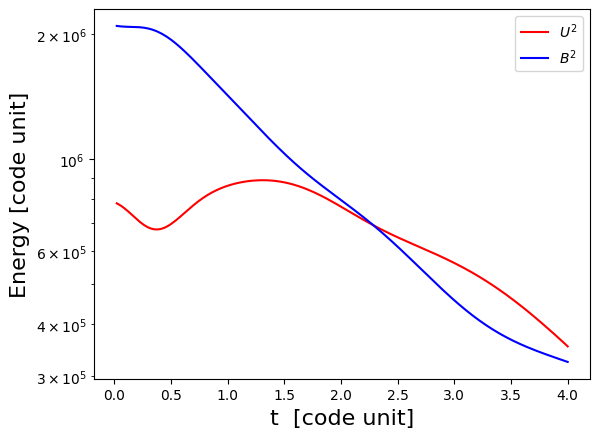

PyObject Text(30.0, 0.5, 'Energy [code unit]')

In [7]:
t  = KE.t[2:end-1];
uu = KE.data[2:end-1];
bb = ME.data[2:end-1];

semilogy(t,uu,"r",label=L"U^2")
semilogy(t,bb,"b",label=L"B^2")
legend()
xlabel("t  [code unit]",size=16)
ylabel("Energy [code unit]",size=16)

In [8]:
CUDA.memory_status()
CUDA.reclaim()
GC.gc(true)
CUDA.memory_status()

Effective GPU memory usage: 100.00% (10.000 GiB/10.000 GiB)
CUDA allocator usage: 9.063 GiB
binned usage: 9.063 GiB (1.766 GiB allocated, 7.297 GiB cached)
Effective GPU memory usage: 29.47% (2.947 GiB/10.000 GiB)
CUDA allocator usage: 1.766 GiB
binned usage: 1.766 GiB (1.391 GiB allocated, 384.000 MiB cached)


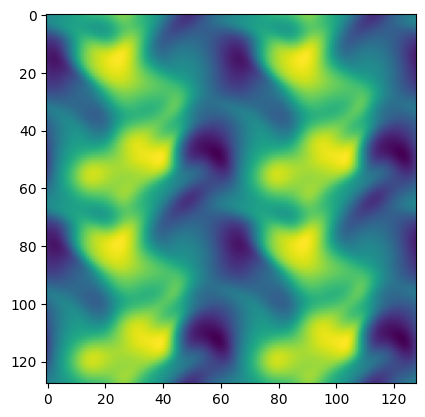

PyObject <matplotlib.image.AxesImage object at 0x7f7962e262e8>

In [9]:
imshow(Array(@view GPUprob.vars.ux[:,:,20]))

# Comparsion between CPU and GPU runtime

In [10]:
CUDA.reclaim()
GC.gc(true)
CUDA.memory_status()

#GPU on 128^3
GPUprob  = MHDProblem(GPU();nx = N,Lx = Lx,
                             ν = ν,
                            nν = 1,
                             η = η, 
              # Timestepper and equation options
                            dt = 1/50,
                       stepper = "RK4",
              # Float type and dealiasing
                             T = Float64);

ProblemGeneratorTG!(GPUprob,2π);
# Actaul computation
@CUDA.time for i = 1:10
    MHDupdatevars!(GPUprob);
    stepforward!(GPUprob,1)
end

Effective GPU memory usage: 25.72% (2.572 GiB/10.000 GiB)
CUDA allocator usage: 1.391 GiB
binned usage: 1.391 GiB (1.391 GiB allocated, 0 bytes cached)
  2.944566 seconds (317.08 k CPU allocations: 20.177 MiB, 3.59% gc time) (3.78 k GPU allocations: 59.282 GiB, 6.52% gc time of which 36.82% spent allocating)


In [11]:
#CPU on 128^3
CPUprob  = MHDProblem(CPU();nx = N,Lx = Lx,
                             ν = ν,
                            nν = 1,
                             η = η, 
              # Timestepper and equation options
                            dt = 1/50,
                       stepper = "RK4",
              # Float type and dealiasing
                             T = Float32);

ProblemGeneratorTG!(CPUprob,2π);
# Actaul computation  
@time for i = 1:10
    MHDupdatevars!(CPUprob);
    stepforward!(CPUprob, [KE, ME],1)
end

 17.822334 seconds (9.59 M allocations: 5.210 GiB, 0.57% gc time)
